In [1]:
%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
from jax import jit, vmap, grad
from jax.lax import scan
from scipy.special import erfcx as sc_erfcx
from scipy.special import wofz as sc_wofz
from jax.scipy.special import erfc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

from exojax.spec import hjert, ljert
from exojax.special import erfcx,rewofz, imwofz, wofzs2

# other implementations of Re(wofz) are given in _special 
from exojax.special._special import rewofz_scan, rewofzt2, rewofzs1

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## these are samples for hjert

In [2]:
from jax import vmap
x=jnp.linspace(0.0,1.0,10)
vmap(hjert,(0,None),0)(x,1.0)

a=jnp.linspace(0.0,1.0,10)
vmap(hjert,(0,0),0)(x,a)

DeviceArray([1.        , 0.87640375, 0.7615196 , 0.6596298 , 0.571879  ,
             0.4976606 , 0.43553388, 0.38377717, 0.34069118, 0.30474418],            dtype=float32)

## exojax version of erfcx 

In [3]:
N=10000
xv=jnp.logspace(-5,5,N)
xvc=np.logspace(-5,5,N)
verfcx=vmap(erfcx)
#%timeit verfcx(xv)

In [4]:
d=(verfcx(xv) - sc_erfcx(xvc))/ sc_erfcx(xvc)

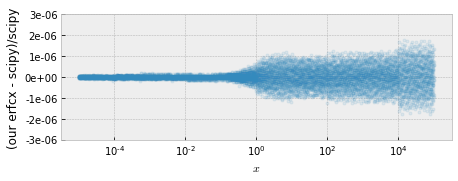

In [5]:
from matplotlib.ticker import FormatStrFormatter

fig=plt.figure(figsize=(7,2.3))
ax=fig.add_subplot(111)
ax.plot(xvc,d,".",alpha=0.1)
ax.yaxis.set_major_formatter(FormatStrFormatter("%1.e"))
plt.ylabel("(our erfcx - scipy)/scipy")
plt.xscale("log")
plt.xlabel("$x$")
plt.ylim(-3.e-6,3.e-6)
plt.savefig("erfcx.pdf", bbox_inches="tight", pad_inches=0.0)

## comparison with scipy.special.wofz

In [6]:
Na=100
vl=-1
vm=3.3
xarrv=jnp.logspace(vl,vm,Na)
xarr=xarrv[:,None]*jnp.ones((Na,Na))
aarrv=jnp.logspace(vl,vm,Na)
aarr=aarrv[None,:]*jnp.ones((Na,Na))

#scipy
def H(a,x):
    z=x+(1j)*a
    w = sc_wofz(z)
    return w.real

# hjert
def vhjert(a):
    return vmap(hjert,(0,None),0)(xarrv,a)
vvhjert=jit(vmap(vhjert,0,0))

In [7]:
%timeit hjert(0.1,0.1)

29.7 µs ± 945 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


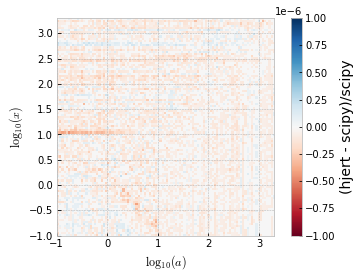

In [8]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
fig=plt.figure()
ax=fig.add_subplot(111)
c=ax.imshow((vvhjert(aarrv).T-H(aarr,xarr))/H(aarr,xarr),vmin=-1.e-6,vmax=1.e-6,
            cmap="RdBu",extent=([vl,vm,vm,vl]))
plt.gca().invert_yaxis()
plt.ylabel("$\log_{10}(x)$")
plt.xlabel("$\log_{10}(a)$")
cb=plt.colorbar(c)
cb.formatter.set_powerlimits((0, 0))
cb.set_label("(hjert - scipy)/scipy",size=14)
plt.savefig("hjert.pdf", bbox_inches="tight", pad_inches=0.0)

In [9]:
#scipy
def L(a,x):
    z=x+(1j)*a
    w = sc_wofz(z)
    return w.imag

# ljert
def vljert(a):
    return vmap(ljert,(0,None),0)(xarrv,a)
vvljert=jit(vmap(vljert,0,0))

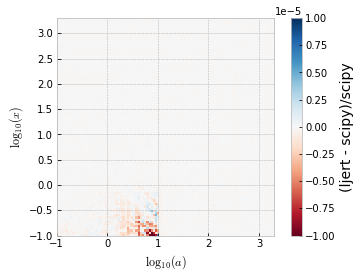

In [11]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
fig=plt.figure()
ax=fig.add_subplot(111)
c=ax.imshow((vvljert(aarrv).T-L(aarr,xarr))/L(aarr,xarr),vmin=-1.e-5,vmax=1.e-5,
            cmap="RdBu",extent=([vl,vm,vm,vl]))
plt.gca().invert_yaxis()
plt.ylabel("$\log_{10}(x)$")
plt.xlabel("$\log_{10}(a)$")
cb=plt.colorbar(c)
cb.formatter.set_powerlimits((0, 0))
cb.set_label("(ljert - scipy)/scipy",size=14)
plt.savefig("ljert.pdf", bbox_inches="tight", pad_inches=0.0)

## example of derivatives of hjert

In [39]:
@jit
def dxH(x,a):
    return 2.0*a*ljert(x,a)-2.0*x*hjert(x,a)

@jit
def daH(x,a):
    return 2.0*x*ljert(x,a)+2.0*a*hjert(x,a)-2.0/jnp.sqrt(np.pi)

In [45]:
sdxH=jit(grad(hjert,argnums=0))
sdaH=jit(grad(hjert,argnums=1))

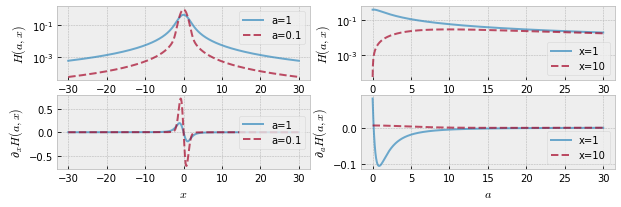

In [57]:
vdxH=jit(vmap(dxH,(0,None),0))
vdaH=jit(vmap(daH,(None,0),0))

vrewofz_ej2 = jit(vmap(hjert,(0,None),0))
gvvrewofz_ej2=jit(vmap(grad(hjert,argnums=0),(0,None),0))

avrewofz_ej2=jit(vmap(hjert,(None,0),0))
agvvrewofz_ej2=jit(vmap(grad(hjert,argnums=1),(None,0),0))

N=1000
xv=jnp.linspace(-30,30,N)
xvc=np.linspace(-30,30,N)

av=jnp.linspace(0.01,30,N)
avc=np.linspace(0.01,30,N)

@jit
def rewofzt2(x,y):
    z=x+y*(1j)
    q=(1j)*z/(jnp.sqrt(jnp.pi))*(z*z - 2.5)/(z*z*(z*z-3.0) + 0.75)
    return jnp.real(q)

#k1=vmap(rewofzs2,(0,None),0)
k1=vmap(rewofzt2,(0,None),0)
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(221)
ax.plot(xv,vrewofz_ej2(xv,1.0),label="a=1",alpha=0.7)
ax.plot(xv,vrewofz_ej2(xv,0.1),label="a=0.1",ls="dashed",alpha=0.7)
#ax.plot(xvc,sc_wofz(xvc+1.0*(1j)).real,ls="dashed")
plt.yscale("log")
plt.ylabel("$H(a,x)$")
plt.legend()

ax=fig.add_subplot(223)
#ax.plot(xv,gvvrewofz_ej2(xv,1.0),label="a=1",alpha=0.7)
#ax.plot(xv,gvvrewofz_ej2(xv,0.1),label="a=0.1",ls="dashed",alpha=0.7)
ax.plot(xv,vdxH(xv,1.0),label="a=1",alpha=0.7)
ax.plot(xv,vdxH(xv,0.1),label="a=0.1",ls="dashed",alpha=0.7)
plt.ylabel("$\partial_x H(a,x)$")
plt.xlabel("$x$")
plt.legend(loc="right")


ax=fig.add_subplot(222)
ax.plot(av,avrewofz_ej2(1.0,av),label="x=1",alpha=0.7)
ax.plot(av,avrewofz_ej2(10.0,av),label="x=10",ls="dashed",alpha=0.7)
plt.yscale("log")
plt.ylabel("$H(a,x)$")
plt.legend()
ax=fig.add_subplot(224)
#ax.plot(av,agvvrewofz_ej2(1.0,av),label="x=1",alpha=0.7)
#ax.plot(av,agvvrewofz_ej2(10.0,av),label="x=10",ls="dashed",alpha=0.7)
ax.plot(av,vdaH(1.0,av),label="x=1",alpha=0.7)
ax.plot(av,vdaH(10.0,av),label="x=10",ls="dashed",alpha=0.7)
plt.xlabel("$a$")
plt.ylabel("$\partial_a H(a,x)$")
plt.legend()
plt.savefig("voigt.pdf", bbox_inches="tight", pad_inches=0.0)

### speed comparison with custom derivative and autodiff

In [88]:
N=1000000
xv=jnp.linspace(-1.0,1.0,N)
av=jnp.linspace(0.01,10.0,N)

In [94]:
%timeit vdxH(xv,0.1)

23.5 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [95]:
%timeit gvvrewofz_ej2(xv,0.1)

54.2 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [96]:
%timeit vdaH(0.1,av)

58 ms ± 507 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [97]:
%timeit agvvrewofz_ej2(0.1,av)

89.1 ms ± 318 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### sanity check

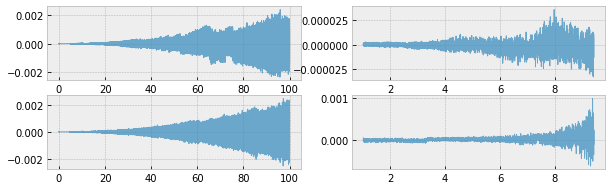

In [103]:
N=1000000
xv=jnp.linspace(0.01,100.0,N)
av=jnp.logspace(0.01,100.0,N)

fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(221)
ax.plot(xv,(vdxH(xv,1.0)-gvvrewofz_ej2(xv,1.0))/gvvrewofz_ej2(xv,1.0),lw=1,label="a=1",alpha=0.7)
ax=fig.add_subplot(223)
ax.plot(xv,(vdxH(xv,0.1)-gvvrewofz_ej2(xv,0.1))/gvvrewofz_ej2(xv,0.1),lw=1,label="a=0.1",alpha=0.7)
ax=fig.add_subplot(222)
ax.plot(av,(vdaH(1.0,av)-agvvrewofz_ej2(1.0,av))/agvvrewofz_ej2(1.0,av),lw=1,label="x=1",alpha=0.7)
ax=fig.add_subplot(224)
ax.plot(av,(vdaH(10.0,av)-agvvrewofz_ej2(10.0,av))/vdaH(10.0,av),lw=1,label="x=10",alpha=0.7)
plt.show()

## comparison with other implementations 

In [6]:
Na=100

xarrv=jnp.logspace(-1,3.3,Na)
xarr=xarrv[:,None]*jnp.ones((Na,Na))
aarrv=jnp.logspace(-1,3.3,Na)
aarr=aarrv[None,:]*jnp.ones((Na,Na))

vrewofz=vmap(rewofz,(0,None),0)
def fvrewofz(a):
    return vrewofz(xarrv,a)
rf=vmap(fvrewofz,0,0)

vrewofz_scan=vmap(rewofz_scan,(0,None),0)
def fvrewofz_scan(a):
    return vrewofz_scan(xarrv,a)
rf_scan=vmap(fvrewofz_scan,0,0)

vf1=vmap(rewofzs1,(0,None),0)
def fvf1(a):
    return vf1(xarrv,a)
fv1=vmap(fvf1,0,0)

vf2=vmap(rewofzs2,(0,None),0)
def fvf2(a):
    return vf2(xarrv,a)
fv2=vmap(fvf2,0,0)

vg2=vmap(rewofzt2,(0,None),0)
def gvf2(a):
    return vg2(xarrv,a)
gv2=vmap(gvf2,0,0)

In [22]:
#rf(aarrv)

In [24]:
%timeit rf(aarrv).T.block_until_ready()
#%timeit rf_scan(aarrv).T.block_until_ready()
%timeit fv1(aarrv).T.block_until_ready()
%timeit fv2(aarrv).T.block_until_ready()
%timeit gv2(aarrv).T.block_until_ready()

448 µs ± 5.78 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
423 µs ± 5.21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
426 µs ± 7.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
438 µs ± 4.54 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [58]:
#derivative x
Na=1000

vrewofz=vmap(grad(rewofz,argnums=0),(0,None),0)
def fvrewofz(a):
    return vrewofz(xarrv,a)
rf=jit(vmap(fvrewofz,0,0))

vrewofz_scan=vmap(grad(rewofz_scan,argnums=0),(0,None),0)
def fvrewofz_scan(a):
    return vrewofz_scan(xarrv,a)
rf_scan=jit(vmap(fvrewofz_scan,0,0))

vf1=vmap(grad(rewofzs1,argnums=0),(0,None),0)
def fvf1(a):
    return vf1(xarrv,a)
fv1=jit(vmap(fvf1,0,0))

vf2=vmap(grad(rewofzs2,argnums=0),(0,None),0)
def fvf2(a):
    return vf2(xarrv,a)
fv2=jit(vmap(fvf2,0,0))

vg2=vmap(grad(rewofzt2,argnums=0),(0,None),0)
def gvf2(a):
    return vg2(xarrv,a)
gv2=jit(vmap(gvf2,0,0))

#%timeit rf_scan(aarrv).T.block_until_ready()
#timeit fv1(aarrv).T.block_until_ready()
#%timeit fv2(aarrv).T.block_until_ready()
#%timeit gv2(aarrv).T.block_until_ready()

#%timeit rf_scan(aarrv).T.block_until_ready()
%timeit rf(aarrv).T.block_until_ready()
%timeit fv1(aarrv).T.block_until_ready()
%timeit fv2(aarrv).T.block_until_ready()
%timeit gv2(aarrv).T.block_until_ready()

2.14 ms ± 26.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
156 µs ± 36.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
178 µs ± 25.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
153 µs ± 14.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
#derivative a
Na=1000

xarrv=jnp.logspace(-1,3.3,Na)
xarr=xarrv[:,None]*jnp.ones((Na,Na))
aarrv=jnp.logspace(-1,3.3,Na)
aarr=aarrv[None,:]*jnp.ones((Na,Na))

vrewofz=vmap(grad(rewofz,argnums=0),(0,None),0)
def fvrewofz(a):
    return vrewofz(xarrv,a)
rf=jit(vmap(fvrewofz,0,0))

vf1=vmap(grad(rewofzs1,argnums=1),(0,None),0)
def fvf1(a):
    return vf1(xarrv,a)
fv1=jit(vmap(fvf1,0,0))

vf2=vmap(grad(rewofzs2,argnums=1),(0,None),0)
def fvf2(a):
    return vf2(xarrv,a)
fv2=jit(vmap(fvf2,0,0))

vg2=vmap(grad(rewofzt2,argnums=1),(0,None),0)
def gvf2(a):
    return vg2(xarrv,a)
gv2=jit(vmap(gvf2,0,0))

In [59]:
%timeit rf(aarrv).T.block_until_ready()
%timeit fv1(aarrv).T.block_until_ready()
%timeit fv2(aarrv).T.block_until_ready()
%timeit gv2(aarrv).T.block_until_ready()

2.24 ms ± 37.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
151 µs ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
147 µs ± 1.64 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
129 µs ± 721 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [5]:
import matplotlib.pyplot as plt
xv=jnp.linspace(-10.0,10.0,N)

In [14]:
N=10000
xv=jnp.linspace(-10.0,10.0,N)
xvc=np.linspace(-10.0,10.0,N)
%timeit vrewofz(xv,1.0)
%timeit sc_wofz(xvc+1.0*(1j)).real

511 µs ± 172 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.15 ms ± 19 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
N=10000
xv=jnp.linspace(-10.0,10.0,N)
xvc=np.linspace(-10.0,10.0,N)
%timeit gvvrewofz(xv,20)

3.37 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


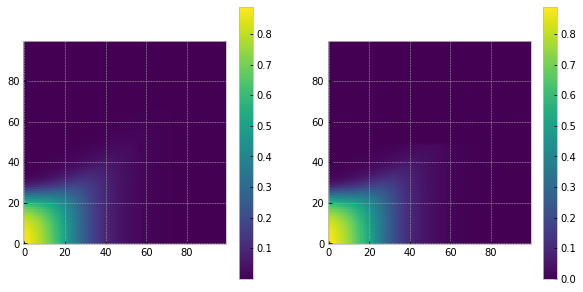

In [15]:
Na=100

xarrv=jnp.logspace(-1,3.3,Na)
xarr=xarrv[:,None]*jnp.ones((Na,Na))

aarrv=jnp.logspace(-1,3.3,Na)
aarr=aarrv[None,:]*jnp.ones((Na,Na))

def H(a,x):
    z=x+(1j)*a
    w = sc_wofz(z)
    return w.real

vrewofz=vmap(rewofz,(0,None),0)
def fvrewofz(a):
    return vrewofz(xarrv,a)
vfvrewofz=vmap(fvrewofz,0,0)

fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(121)
c=ax.imshow(H(aarr,xarr))
plt.colorbar(c)
plt.gca().invert_yaxis()
ax=fig.add_subplot(122)
c2=ax.imshow(vfvrewofz(aarrv).T)
plt.colorbar(c2)
plt.gca().invert_yaxis()


In [73]:
vf1=vmap(rewofzs1,(0,None),0)
def fvf1(a):
    return vf1(xarrv,a)
fv1=vmap(fvf1,0,0)

vf2=vmap(rewofzs2,(0,None),0)
def fvf2(a):
    return vf2(xarrv,a)
fv2=vmap(fvf2,0,0)

vg2=vmap(rewofzt2,(0,None),0)
def gvf2(a):
    return vg2(xarrv,a)
gv2=vmap(gvf2,0,0)

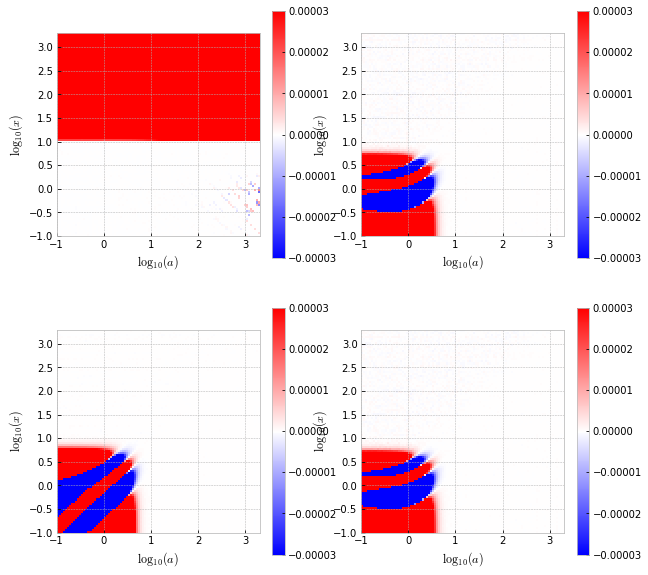

In [74]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(221)
c=ax.imshow((H(aarr,xarr)-vfvrewofz(aarrv).T)/H(aarr,xarr),vmin=-3.e-5,vmax=3.e-5,
            cmap="bwr",extent=([-1,3.3,3.3,-1]))
plt.gca().invert_yaxis()
plt.ylabel("$\log_{10}(x)$")
plt.xlabel("$\log_{10}(a)$")
plt.colorbar(c)
ax=fig.add_subplot(222)
c=ax.imshow((H(aarr,xarr)-gv2(aarrv).T)/H(aarr,xarr),vmin=-3.e-5,vmax=3.e-5,
            cmap="bwr",extent=([-1,3.3,3.3,-1]))
plt.gca().invert_yaxis()
plt.ylabel("$\log_{10}(x)$")
plt.xlabel("$\log_{10}(a)$")
plt.colorbar(c)
ax=fig.add_subplot(223)
c=ax.imshow((H(aarr,xarr)-fv2(aarrv).T)/H(aarr,xarr),vmin=-3.e-5,vmax=3.e-5,
            cmap="bwr",extent=([-1,3.3,3.3,-1]))
plt.gca().invert_yaxis()
plt.ylabel("$\log_{10}(x)$")
plt.xlabel("$\log_{10}(a)$")
plt.colorbar(c)
ax=fig.add_subplot(224)
c=ax.imshow((H(aarr,xarr)-gv2(aarrv).T)/H(aarr,xarr),vmin=-3.e-5,vmax=3.e-5,
            cmap="bwr",extent=([-1,3.3,3.3,-1]))
plt.gca().invert_yaxis()
plt.ylabel("$\log_{10}(x)$")
plt.xlabel("$\log_{10}(a)$")
plt.colorbar(c)


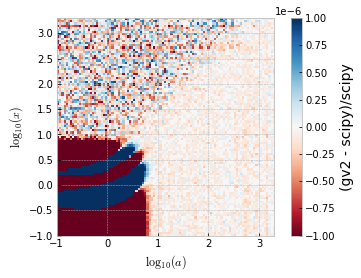

In [75]:
# rewofzt2 has worse error than rewofzs2
"""
In the paper, we stated, 
- The other asymptotic representation in Zaghloul (2018),
w(z) =iz/√π(z2−2.5)/(z2(z2−3)+0.75) is a bit faster than Re[ws2(x+ia)]. 
However, the residual fromscipy.wofzis one order magnitudelarger than Re[ws2(x+ia)]
"""

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
fig=plt.figure()
ax=fig.add_subplot(111)
c=ax.imshow((gv2(aarrv).T-H(aarr,xarr))/H(aarr,xarr),vmin=-1.e-6,vmax=1.e-6,
            cmap="RdBu",extent=([-1,3.3,3.3,-1]))
plt.gca().invert_yaxis()
plt.ylabel("$\log_{10}(x)$")
plt.xlabel("$\log_{10}(a)$")
cb=plt.colorbar(c)
cb.formatter.set_powerlimits((0, 0))
cb.set_label("(gv2 - scipy)/scipy",size=14)


In [7]:
gvvrewofz_ej1=jit(vmap(grad(rewofz_ej1,argnums=0),(0,None),0))
gvvrewofz_ej2=jit(vmap(grad(rewofz_ej2,argnums=0),(0,None),0))
gvvrewofz=jit(vmap(grad(rewofz,argnums=0),(0,None),0))
#N=1000000
#xv=jnp.linspace(-1000.0,1000.0,N)
%timeit rf(aarrv).T.block_until_ready()
%timeit vfvrewofz_ej2(aarrv).T.block_until_ready()


12.1 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.8 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


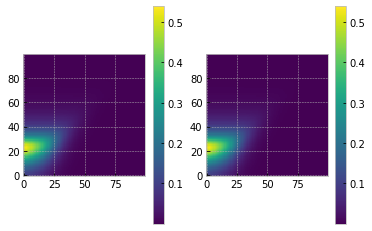

In [18]:
Na=100

xarrv=jnp.logspace(-1,3.3,Na)
xarr=xarrv[:,None]*jnp.ones((Na,Na))

aarrv=jnp.logspace(-1,3.3,Na)
aarr=aarrv[None,:]*jnp.ones((Na,Na))

def iH(a,x):
    z=x+(1j)*a
    w = sc_wofz(z)
    return w.imag

vimwofz=vmap(imwofz,(0,None),0)
def fvimwofz(a):
    return vimwofz(xarrv,a)
vfvimwofz=vmap(fvimwofz,0,0)

fig=plt.figure()
ax=fig.add_subplot(121)
c=ax.imshow(iH(aarr,xarr))
plt.colorbar(c)
plt.gca().invert_yaxis()
ax=fig.add_subplot(122)
c2=ax.imshow(vfvimwofz(aarrv).T)
plt.colorbar(c2)
plt.gca().invert_yaxis()

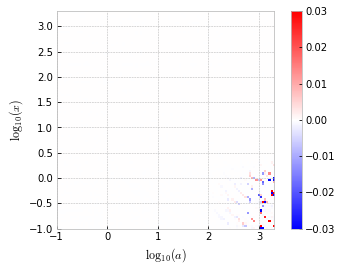

In [19]:
fig=plt.figure()
ax=fig.add_subplot(111)
#c=ax.imshow(np.log10(np.abs(H(aarr,xarr)-Tc(aarr,xarr))/H(aarr,xarr)),cmap="bwr",vmin=-1,vmax=1)
#c=ax.imshow(H(aarr,xarr))
#c=ax.imshow(vfvrewofz(aarrv))
c=ax.imshow((iH(aarr,xarr)-vfvimwofz(aarrv).T)/iH(aarr,xarr),vmin=-3.e-2,vmax=3.e-2,
            cmap="bwr",extent=([-1,3.3,3.3,-1]))
plt.ylabel("$\log_{10}(x)$")
plt.xlabel("$\log_{10}(a)$")
plt.colorbar(c)
plt.gca().invert_yaxis()

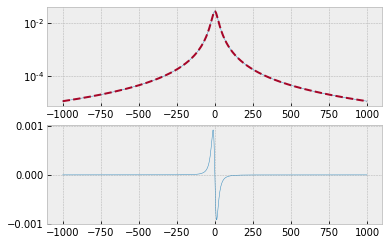

In [10]:
vrewofzx=vmap(jit(rewofzx),(0,None),0)
gvvrewofzx=vmap(grad(jit(rewofzx),argnums=0),(0,None),0)

N=1000
xv=jnp.linspace(-1000,1000,N)
xvc=np.linspace(-1000,1000,N)

fig=plt.figure()
ax=fig.add_subplot(211)
ax.plot(xv,vrewofzx(xv,20),lw=0.5)
ax.plot(xvc,sc_wofz(xvc+20*(1j)).real,ls="dashed")
plt.yscale("log")
ax=fig.add_subplot(212)
ax.plot(xv,gvvrewofzx(xv,20),lw=0.5)